In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import itertools
import os
import warnings
warnings.filterwarnings('ignore')
import copy

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn import decomposition
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.manifold import TSNE

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter


In [2]:
# test different datasets
datasets = []


## Data Acquisition
##### Flat Acquisition using csv files

In [3]:
# Reading the csv files into dataframes.
movies = pd.read_csv('./data/movies.csv')
ratings = pd.read_csv('./data/ratings.csv')
tags = pd.read_csv('./data/tags.csv')
genome_scores = pd.read_csv('./data/genome-scores.csv')
genome_tags = pd.read_csv('./data/genome-tags.csv')


In [4]:
# Printing the first 5 rows of each dataframe.
print('Movies:')
display(movies.head())
print('Ratings:')
display(ratings.head())
print('Tags:')
display(tags.head())
print('Genome Scores:')
display(genome_scores.head())
print('Genome Tags:')
display(genome_tags.head())


Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Ratings:


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


Tags:


,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


Genome Scores:


,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


Genome Tags:


,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Data Wrangling

In [5]:
# ratings group by movieId with mean and count
grouped_ratings = ratings.groupby('movieId').agg({'rating': ['mean', 'count'], 'timestamp': ['mean']})
grouped_ratings.columns = ['mean_rating', 'rating_count', 'mean_timestamp']
grouped_ratings = grouped_ratings.astype({'mean_timestamp': 'int'})

# Dataset merge with movies and ratings, with missing rating films removed
df = pd.merge(movies, grouped_ratings, on='movieId')

display(df.head())


,movieId,title,genres,mean_rating,rating_count,mean_timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.893708,57309,1153152210
1,2,Jumanji (1995),Adventure|Children|Fantasy,3.251527,24228,1122310117
2,3,Grumpier Old Men (1995),Comedy|Romance,3.142028,11804,980602256
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,2.853547,2523,942460471
4,5,Father of the Bride Part II (1995),Comedy,3.058434,11714,1004723013


In [6]:
# Group by tagId and compute mean relevance
mean_relevance = genome_scores.groupby('tagId').mean()['relevance']

# Threshold filters out tags with low mean relevance
threshold = 0.0
good_tags = mean_relevance.where(mean_relevance > threshold).dropna().index
genome_scores_2 = genome_scores[genome_scores['tagId'].isin(good_tags)]

# Merge movies with genome scores
genome_scores_2['tag'] = genome_scores_2['tagId'].map(genome_tags.set_index('tagId')['tag'].to_dict())
genome_table = genome_scores_2.pivot_table(index='movieId', columns='tag', values='relevance')

# Merge movies with genome table
df = pd.merge(df, genome_table, on='movieId')


### Data Preparation (Data cleaning, Duplicates filtering, Data encoding)

##### Data Cleaning

In [7]:
# print number of rows
print('Number of rows: ', df.shape[0])

# fill rows with missing values (there are films with no tags, so we fill these tag columns set to 0)
df = df.dropna(0)

# print number of rows after dropping missing values
print('Number of rows after dropping missing values: ', df.shape[0])


Number of rows:  13816
Number of rows after dropping missing values:  13816


##### Data Encoding
Multicategorical One-Hot encoding for film genres

In [8]:
# one hot encoding for genres
categories = set()
for s in df['genres'].str.split('|').values:
    if s != ['(no genres listed)']:
        categories = categories.union(set(s))

# print(categories)

# add columns for each category
for category in categories:
    df[category] = df['genres'].str.contains(category).astype(int)

# delete genres column
df = df.drop(columns=['genres'])


##### Duplicates Filtering
The following results show that there are no duplicates in the dataset.

In [9]:
# print number of rows
print('Number of rows: ', df.shape[0])

# drop duplicated rows
df = df.drop_duplicates()

# print number of rows after dropping missing values
print('Number of rows after dropping duplicated rows: ', df.shape[0])


Number of rows:  13816
Number of rows after dropping duplicated rows:  13816


## Data Visualization

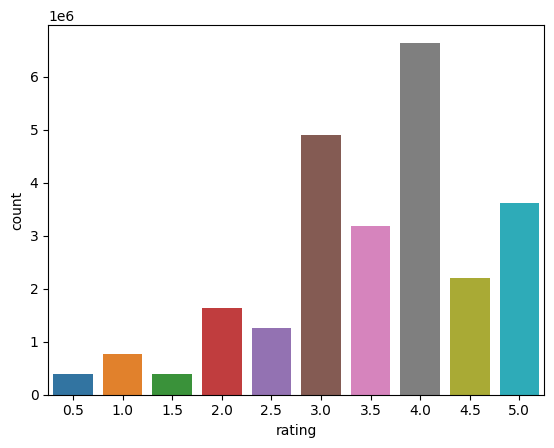

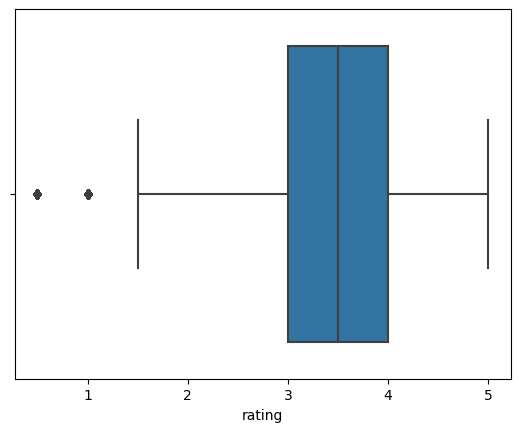

In [10]:
# rating distribution from ratings.csv
sns.countplot(x='rating', data=ratings)
plt.show()

sns.boxplot(x='rating', data=ratings)
plt.show()


Rather than using discrete bins, a KDE plot smooths the observations with a Gaussian kernel, producing a continuous density estimate. This is used for continuous attributes like rating mean.

It is done to show differences after data aggregation in calculating mean for each film.

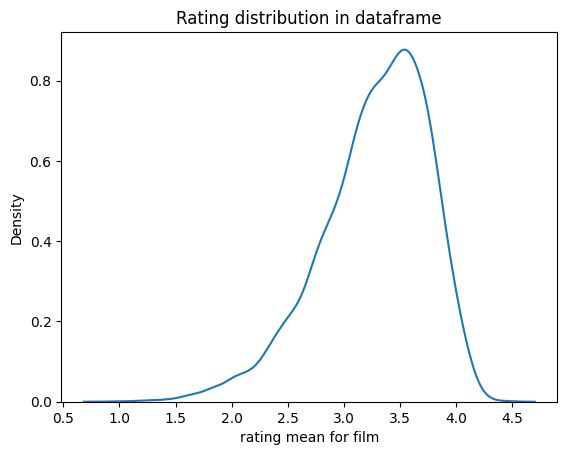

In [11]:
# rating distribution from df
sns.kdeplot(df['mean_rating'])
plt.xlabel('rating mean for film')
plt.title('Rating distribution in dataframe')
plt.show()


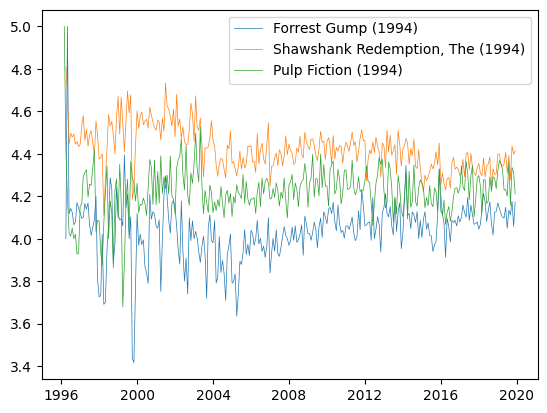

In [12]:
movies_to_show = 3

most_rated_movies = ratings.groupby('movieId').count().sort_values('rating', ascending=False).head(movies_to_show).index

for i in range(movies_to_show):
    data = ratings.where(ratings['movieId'] == most_rated_movies[i]).dropna()
    data['date'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Computing the mean for each month
    data = data.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    movie_title = movies.where(movies['movieId'] == most_rated_movies[i]).dropna()['title'].values[0]
    data['title'] = movie_title
    
    # Visualization
    x = data.index
    y = data['rating']
    plt.plot(x, y, label=movie_title, linewidth=0.5)

plt.legend()
plt.show()

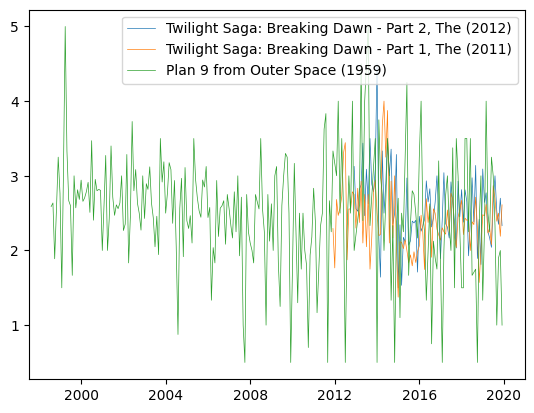

In [13]:
# Same as above cell but the 3 movies with the highest standard deviation
movies_to_show = 3

# Take movies with at least 1000 ratings
high_std_movies = ratings.where(
    ratings['movieId']
    .isin(ratings.groupby('movieId')
          .count()
          .where(ratings.groupby('movieId').count()['rating'] > 1000)
          .dropna().index)
    ).dropna()

high_std_movies = high_std_movies.groupby('movieId').std().sort_values('rating', ascending=False).head(movies_to_show).index

to_line_plot = []
for i in range(movies_to_show):
    data = ratings.where(ratings['movieId'] == high_std_movies[i]).dropna()
    data['date'] = pd.to_datetime(data['timestamp'], unit='s')
    
    # Computing the mean for each month
    data = data.resample("M", on='date').mean()[['movieId', 'rating']].dropna()
    movie_title = movies.where(movies['movieId'] == high_std_movies[i]).dropna()['title'].values[0]
    
    # Visualization
    x = data.index
    y = data['rating']
    plt.plot(x, y, label=movie_title, linewidth=0.5)

# Print the titles of the movies
plt.legend()
plt.show()

Plot density for every attribute of dataset

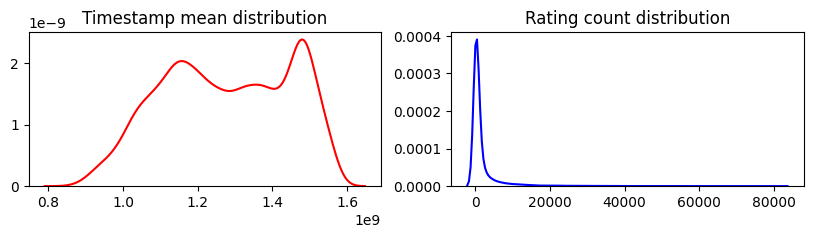

In [14]:
# print distribution for ratings
fig, axs = plt.subplots(1, 2, figsize=(10, 2))
sns.kdeplot(df['mean_timestamp'], ax=axs[0], color='r', label='timestamp')
sns.kdeplot(df['rating_count'], ax=axs[1], color='b', label='rating')

axs[0].set_xlabel('')
axs[0].set_ylabel('')
axs[0].title.set_text('Timestamp mean distribution')
axs[1].set_xlabel('')
axs[1].set_ylabel('')
axs[1].title.set_text('Rating count distribution')
plt.show()


Number of movies with rating_count < 50:  642
Number of all movies:  13816


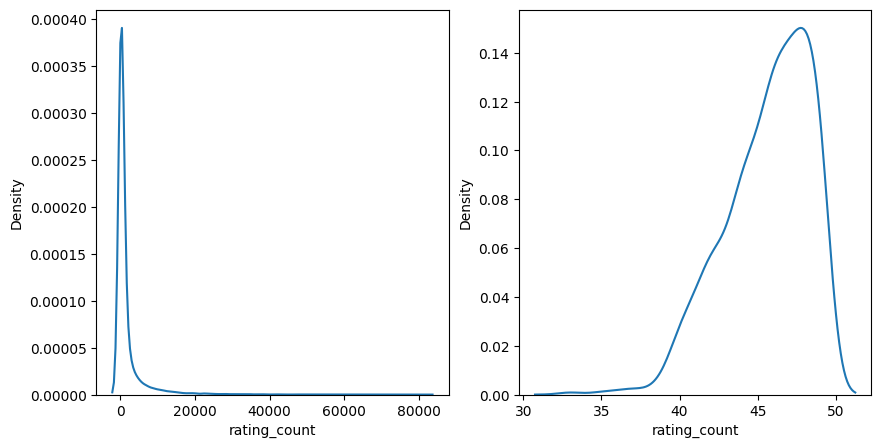

In [15]:
# density plot for rating_count
fig, axs = plt.subplots(1,2, figsize=(10, 5))
sns.kdeplot(df['rating_count'], ax=axs[0], label='rating_count')
sns.kdeplot(df['rating_count'].where(df['rating_count'] < 50), ax=axs[1], label='rating_count < 50')

print('Number of movies with rating_count < 50: ', df.where(df['rating_count'] < 50).count()[0])
print('Number of all movies: ', df.shape[0])


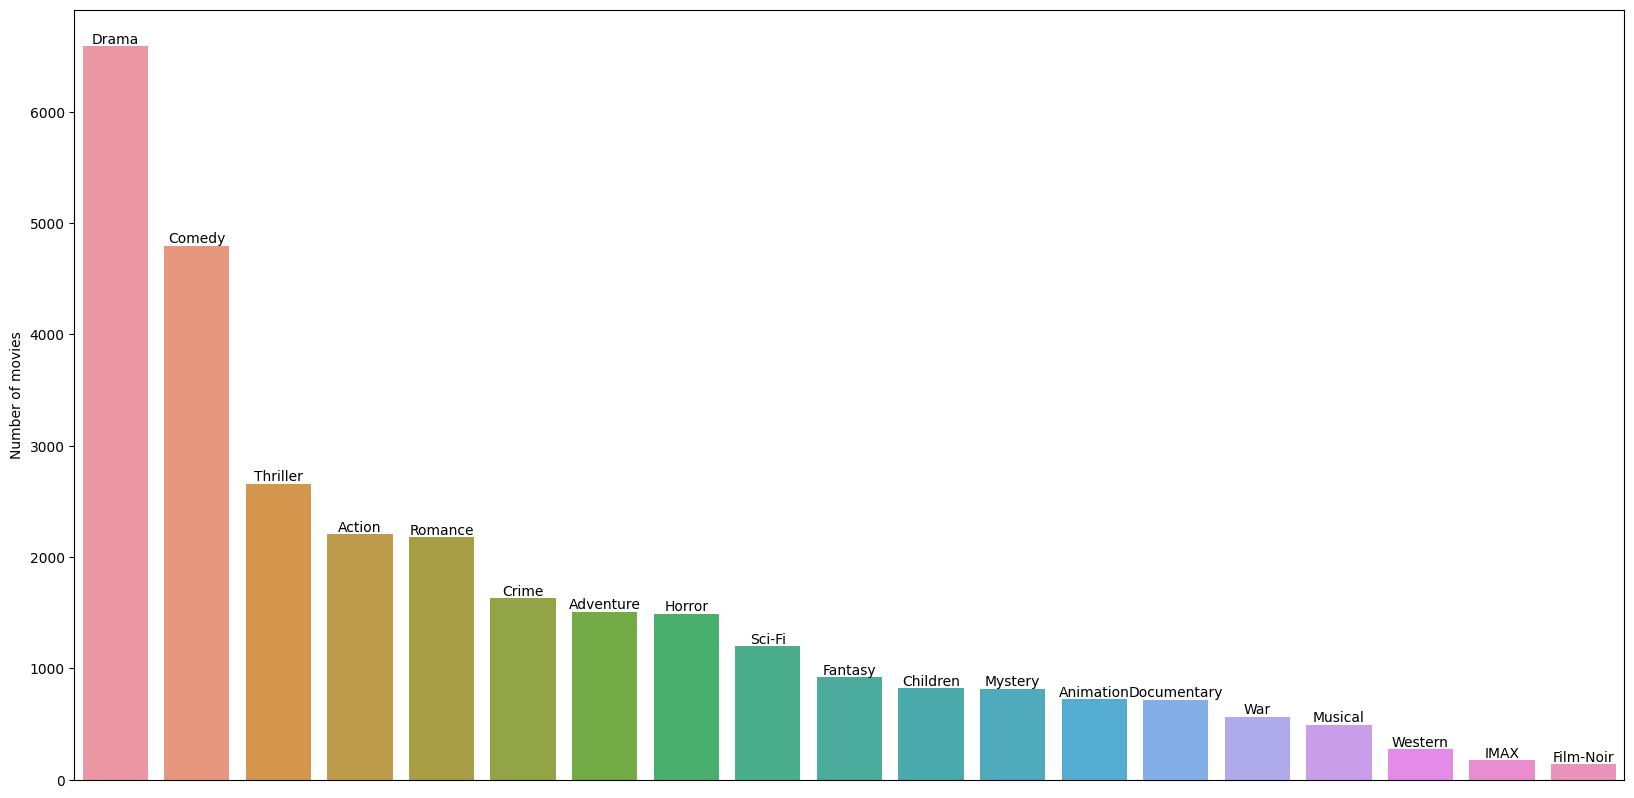

In [16]:
# plot for categories
cat = list(categories)

# count the number of rows containing 1 for each category
cat_dict = {}
for category in cat:
    cat_dict[category] = df[category].sum()

# order the dictionary by value in descending order
cat_dict = {k: v for k, v in sorted(cat_dict.items(), key=lambda item: item[1], reverse=True)}

# plot an histogram of the number of rows for each category
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
ax = sns.barplot(x=list(cat_dict.keys()), y=list(cat_dict.values()))
ax.bar_label(container=ax.containers[0], labels=list(cat_dict.keys()))
ax.set_ylabel('Number of movies')
plt.xticks([])
plt.show()


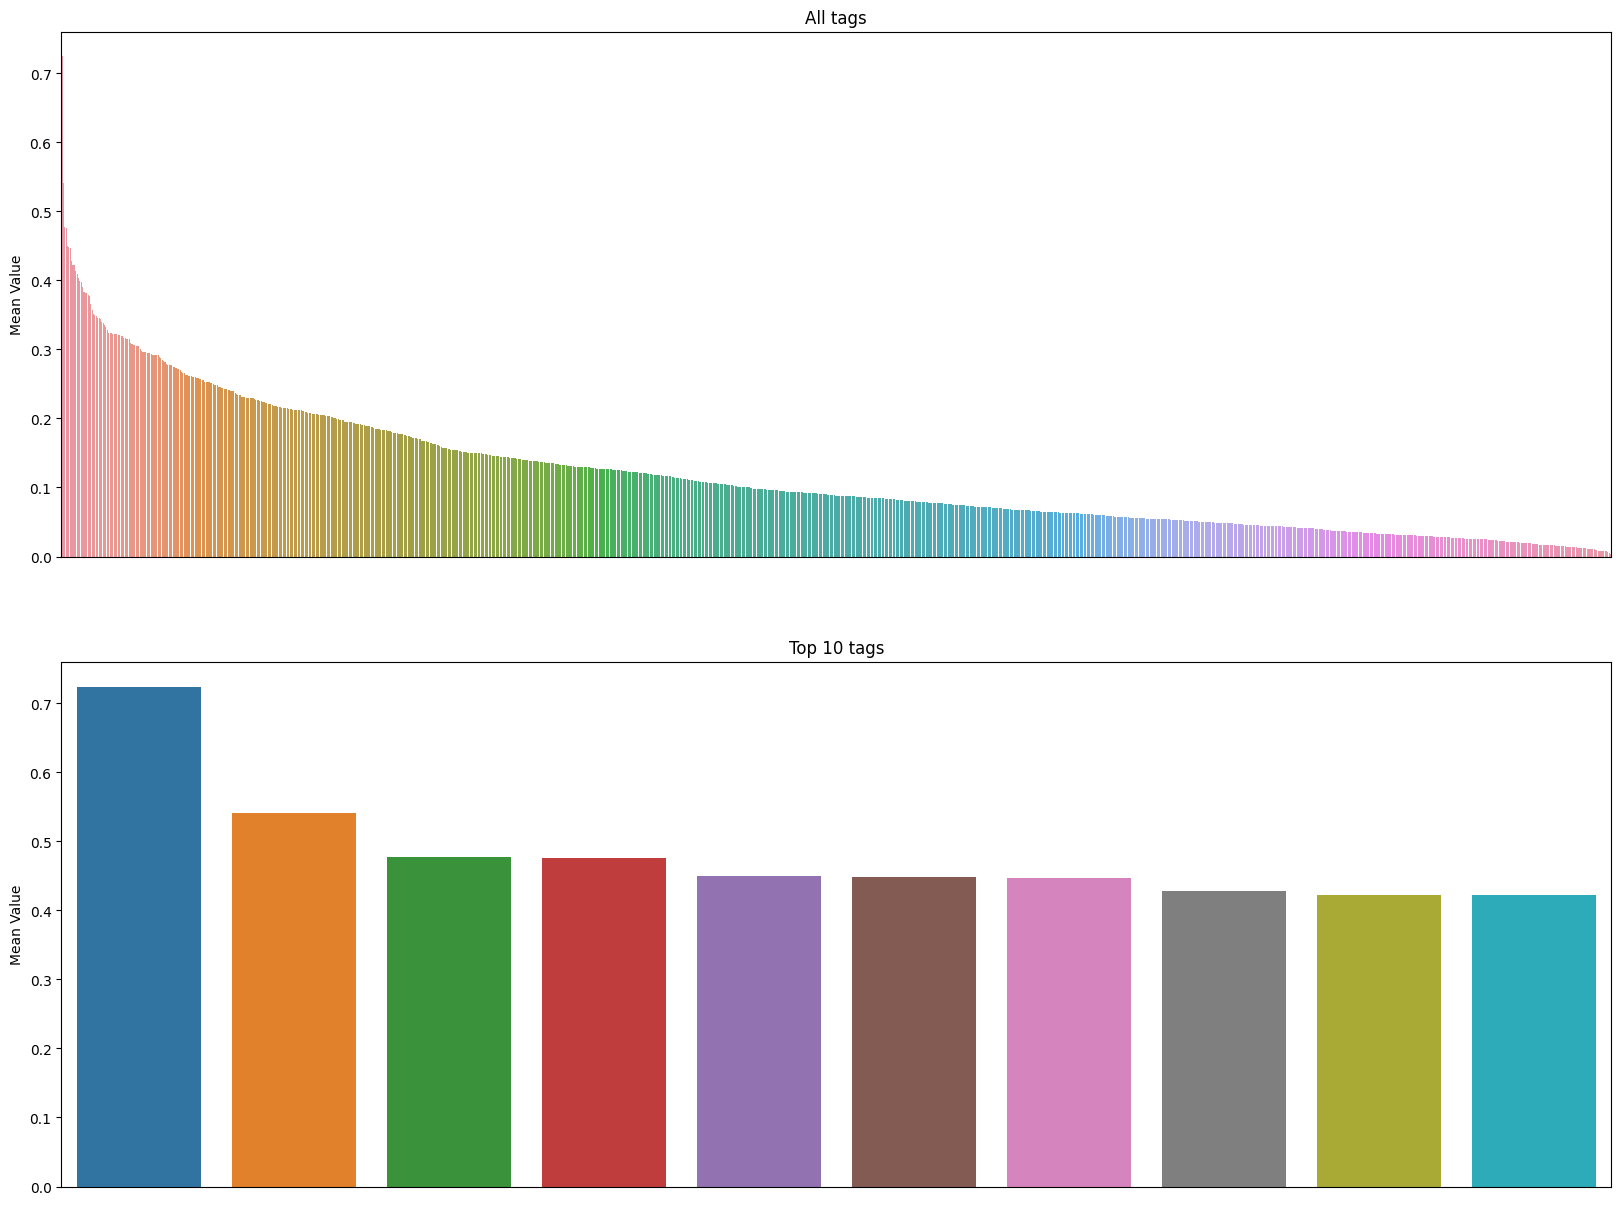

In [17]:
# plot for tags

tag_columns = list(df.columns)
tag_columns = df.drop(columns=['movieId','title','mean_rating','rating_count', 'mean_timestamp']).columns
tag_columns = [tag for tag in tag_columns if tag not in categories]

tag_dict = {}
for tag in tag_columns:
    tag_dict[tag] = df[tag].mean()

# order the dictionary by value in descending order and plot the first 10
tag_dict = {k: v for k, v in sorted(tag_dict.items(), key=lambda item: item[1], reverse=True)}

# display('Tag mean: ', tag_dict)

fig, axs = plt.subplots(2, 1, figsize=(20, 15))
ax1 = sns.barplot(x=list(tag_dict.keys())[:], y=list(tag_dict.values())[:] , ax=axs[0])
ax1.xaxis.set_ticks([])
ax1.set_title('All tags')
ax1.set_ylabel('Mean Value')
ax2 = sns.barplot(x=list(tag_dict.keys())[:10], y=list(tag_dict.values())[:10] , ax=axs[1])
ax2.bar_label(container=ax.containers[0], labels=list(tag_dict.keys())[:10])
ax2.set_title('Top 10 tags')
ax2.set_ylabel('Mean Value')
plt.xticks([])
plt.show()


In [18]:
# count the number of rows containing 1 for Film-Noir and IMAX
print('Number of Film-Noir movies: ', df['Film-Noir'].sum())
print('Number of IMAX movies: ', df['IMAX'].sum())


Number of Film-Noir movies:  138
Number of IMAX movies:  173


## Data Preprocessing

In [19]:
df_title = df['title']

# delete title and movieId columns
df = df.drop(columns=['movieId', 'title'])
# dataset['data'] = df

# from title extract year
df['year'] = df_title.str.extract('(\(\d{4}\))', expand=True)
# remove parentheses
df['year'] = df['year'].str.extract('(\d{4})', expand=True)

# remove movies with no year
df = df.dropna(subset=['year'])

# convert year to int
df['year'] = df['year'].astype(int)
   

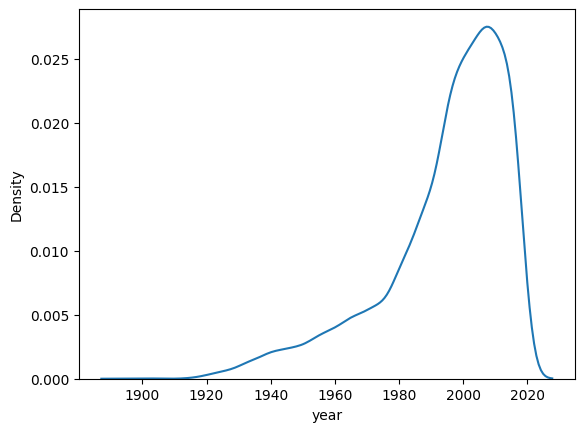

In [20]:
# density plot for film year
sns.kdeplot(df['year'])
plt.show()


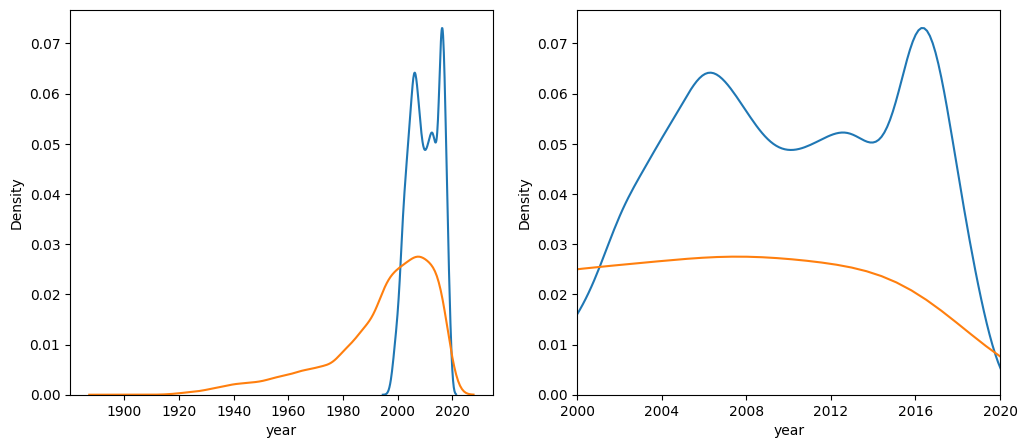

In [21]:
# show year and year_timestamp in the same plot with values from 2000 to 2020
df_year = df.copy()
df_year['mean_timestamp'] = pd.to_datetime(df['mean_timestamp'], unit='s')
df_year['year_timestamp'] = df_year['mean_timestamp'].dt.year

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.kdeplot(df_year['year_timestamp'], ax=axs[0], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[0], label='film year')
axs[0].set_xlabel('year')
sns.kdeplot(df_year['year_timestamp'], ax=axs[1], label='timestamp year')
sns.kdeplot(df_year['year'], ax=axs[1], label='film year')
axs[1].set_xlabel('year')
axs[1].set_xlim(2000, 2020)
axs[1].set_xticks(np.arange(2000, 2022, 4))
plt.show()


In [22]:
# TAGS AND GENRES: No drop


### Transformation

In [23]:
# raw data - set all values to float
df = df.astype(float)
df = df.dropna()


### Correlation results
This correlation table shows the relationship between different movie genres and several movie characteristics such as mean rating, rating count, and year of release. The values in the table represent the Pearson correlation coefficient, which ranges from -1 to 1 and measures the linear association between two variables. Positive values indicate a positive association, meaning that as one variable increases, the other variable also increases. Negative values indicate a negative association, meaning that as one variable increases, the other variable decreases.

<!-- Some observations from the table:

There is a positive correlation between the mean rating and rating count of a movie (0.13). This indicates that movies with higher ratings tend to have more ratings.
Film-Noir has a moderate positive correlation with Crime (0.15) and Mystery (0.06). This suggests that movies classified as Film-Noir often have elements of crime and mystery.
Horror movies have a negative correlation with mean rating (-0.22), indicating that they tend to have lower ratings.
Drama movies have a moderate positive correlation with mean rating (0.15) and a moderate positive correlation with Thriller movies (0.24).
There is a negative correlation between year of release and rating count (-0.27), which suggests that older movies tend to have fewer ratings.
In conclusion, this table provides useful information about the relationship between different movie genres and movie characteristics, and can be used to make informed decisions about movie selection and production. -->

### Covariance results
Covariance is a measure of the linear relationship between two variables. It measures how changes in one variable are associated with changes in the other variable. Covariance is expressed as a numerical value and can range from negative to positive values. A positive covariance means that the two variables are positively related, while a negative covariance means that they are inversely related. A covariance of zero means that there is no linear relationship between the variables (i.e. variables are indipendent).

<!-- In the table provided, the covariance between two variables can be found in the entries of the matrix. For example, the covariance between "mean_rating" and "Film-Noir" is 0.001774, indicating a very small positive relationship between the two variables. The covariance between "rating_count" and "Crime" is 43.331685, indicating a stronger positive relationship between these two variables.

It's important to keep in mind that covariance only measures linear relationships, so it may not be able to fully capture more complex relationships between variables.

As it's possible to see in the table, variables tend to be indipendent from each others, this is not valid only for two variables: rating_count and mean_timestamp. These two attributes are highly dipendent with all other attributes. -->

### Dataset Describe
The describe() function applied on the Pandas DataFrame provides statistical information about the features in the DataFrame. 

<!-- According to the results, the mean rating for the movies is 3.110263, with a standard deviation of 0.653225. The minimum and maximum ratings are 0.5 and 5, respectively. The mean count of ratings for each movie is 596.81, with a standard deviation of 2929.96. -->

<!-- The genre columns (Film-Noir, Crime, Mystery, Animation, etc.) are binary, with a mean of either 0 or 0.01 to 0.28. The 25th, 50th, and 75th percentiles for these features are either 0 or close to 0, indicating that the majority of the movies belong to a particular genre. The year_timestamp feature has a mean of 2014.22, with a standard deviation of 4.7. The year feature has a mean of 1991.57 and a standard deviation of 25.09. -->


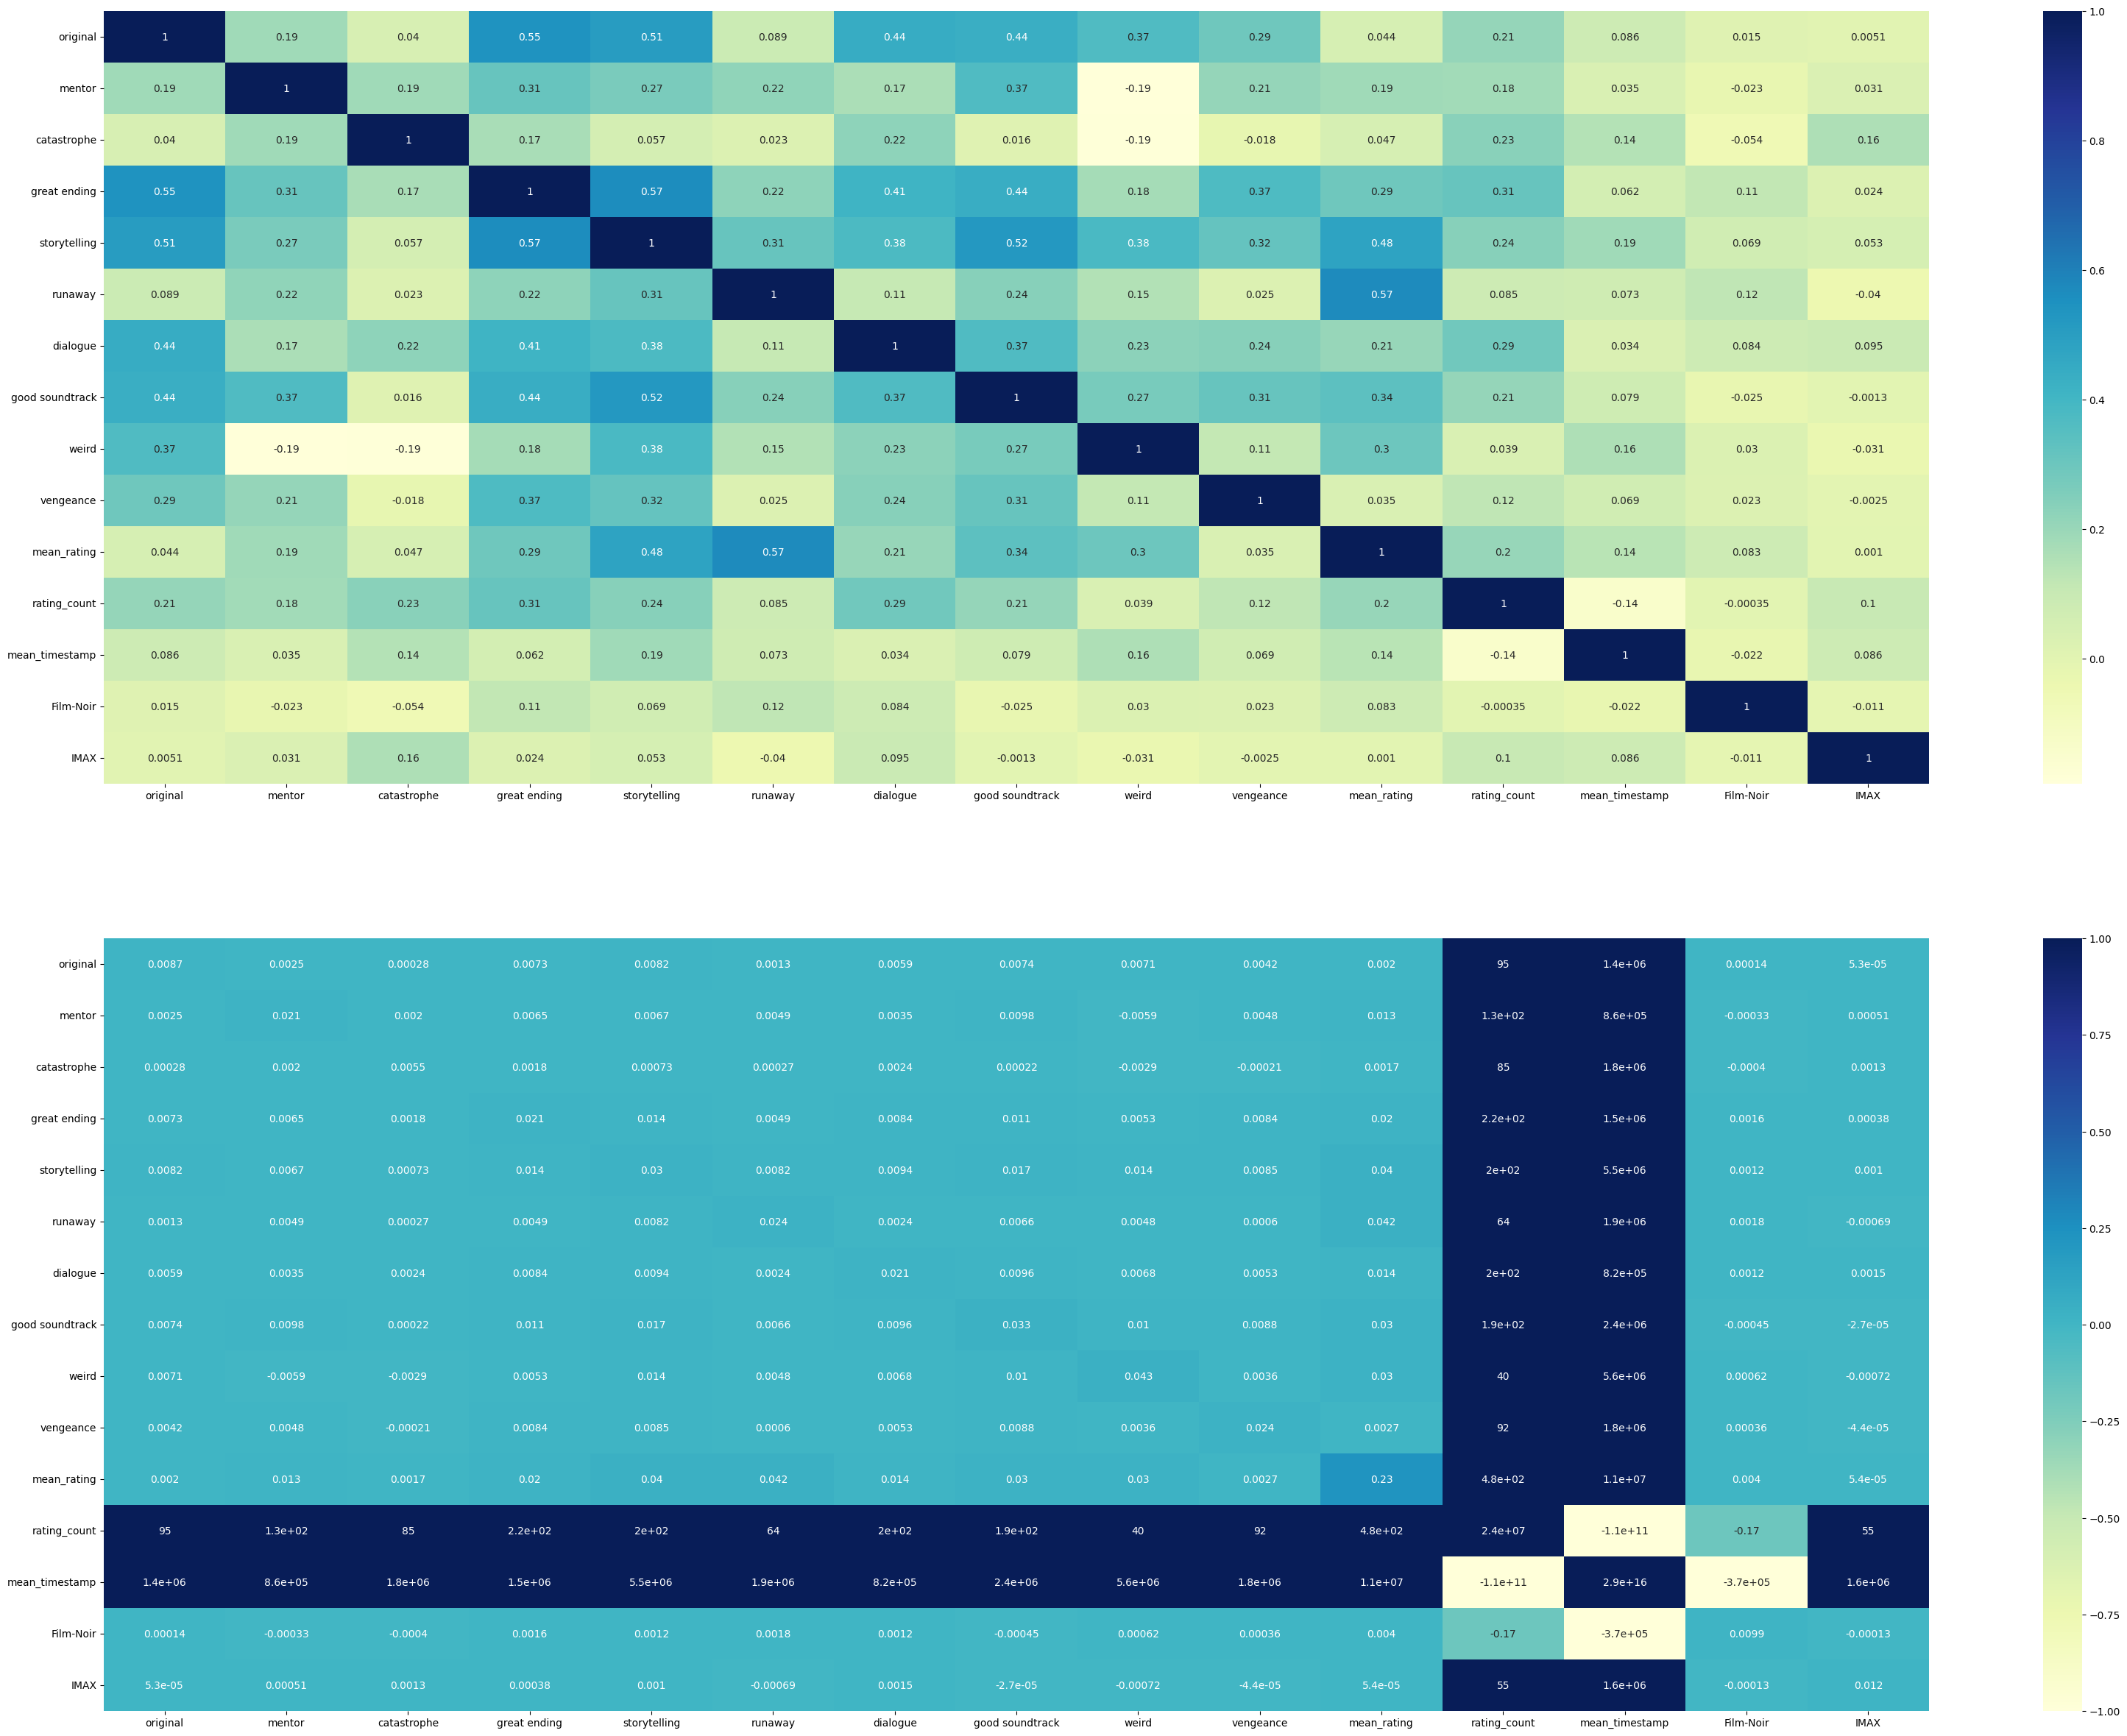

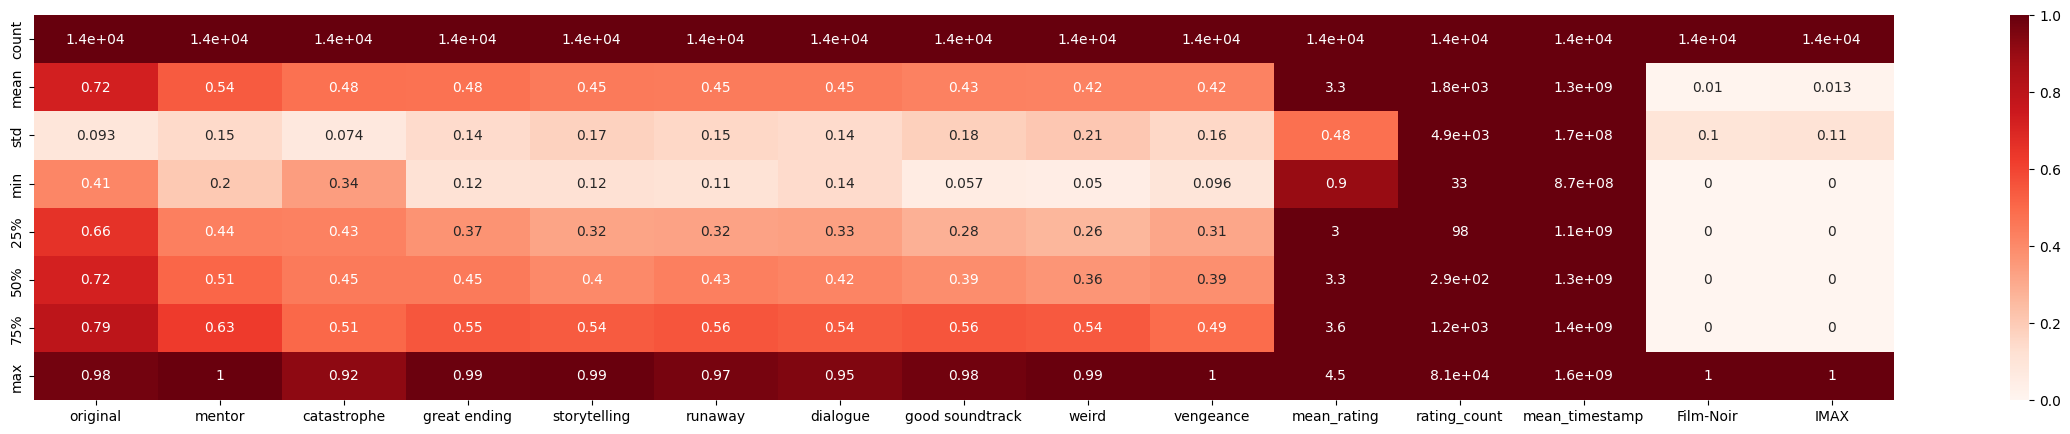

In [24]:
# compute analysis for 'mean_rating', 'rating_count', 'mean_timestamp', 'Film-Noir', 'IMAX' and first 10 tags based on relevance

list_to_compute = list(tag_dict.keys())[:10]

list_to_compute.append('mean_rating')
list_to_compute.append('rating_count')
list_to_compute.append('mean_timestamp')
list_to_compute.append('Film-Noir')
list_to_compute.append('IMAX')

corr = df[list_to_compute].corr()
# print(corr)
cov = df[list_to_compute].cov()
# print(cov)
desc = df[list_to_compute].describe()
# print(desc)

# follow examples from slides on Data Visualization (pages 6-8)
fig, axs = plt.subplots(2, 1, figsize=(40, 30))
# show results of correlation in a graphic way
# Plot the heatmap of the correlation matrix
sns.heatmap(corr, annot=True, cmap="YlGnBu", ax=axs[0])
# show results of covariance in a graphic way
# Plot the heatmap of the covariance matrix
sns.heatmap(cov, annot=True, cmap="YlGnBu", ax=axs[1], vmax=1, vmin=-1)

plt.show()

# Plot the table
plt.figure(figsize=(30, 5))
sns.heatmap(desc, annot=True, cmap='Reds', vmax=1, vmin=0)
plt.show()




In [25]:
# Split data
X = df.drop(columns=['mean_rating'])
y = df['mean_rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# save the data in a csv file
X_train.to_csv('X_train.csv', index=False)
X_val.to_csv('X_val.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_val.to_csv('y_val.csv', index=False)
y_test.to_csv('y_test.csv', index=False)



### TSNE

Perplexity: 5
Perplexity: 30
Perplexity: 50
Perplexity: 100


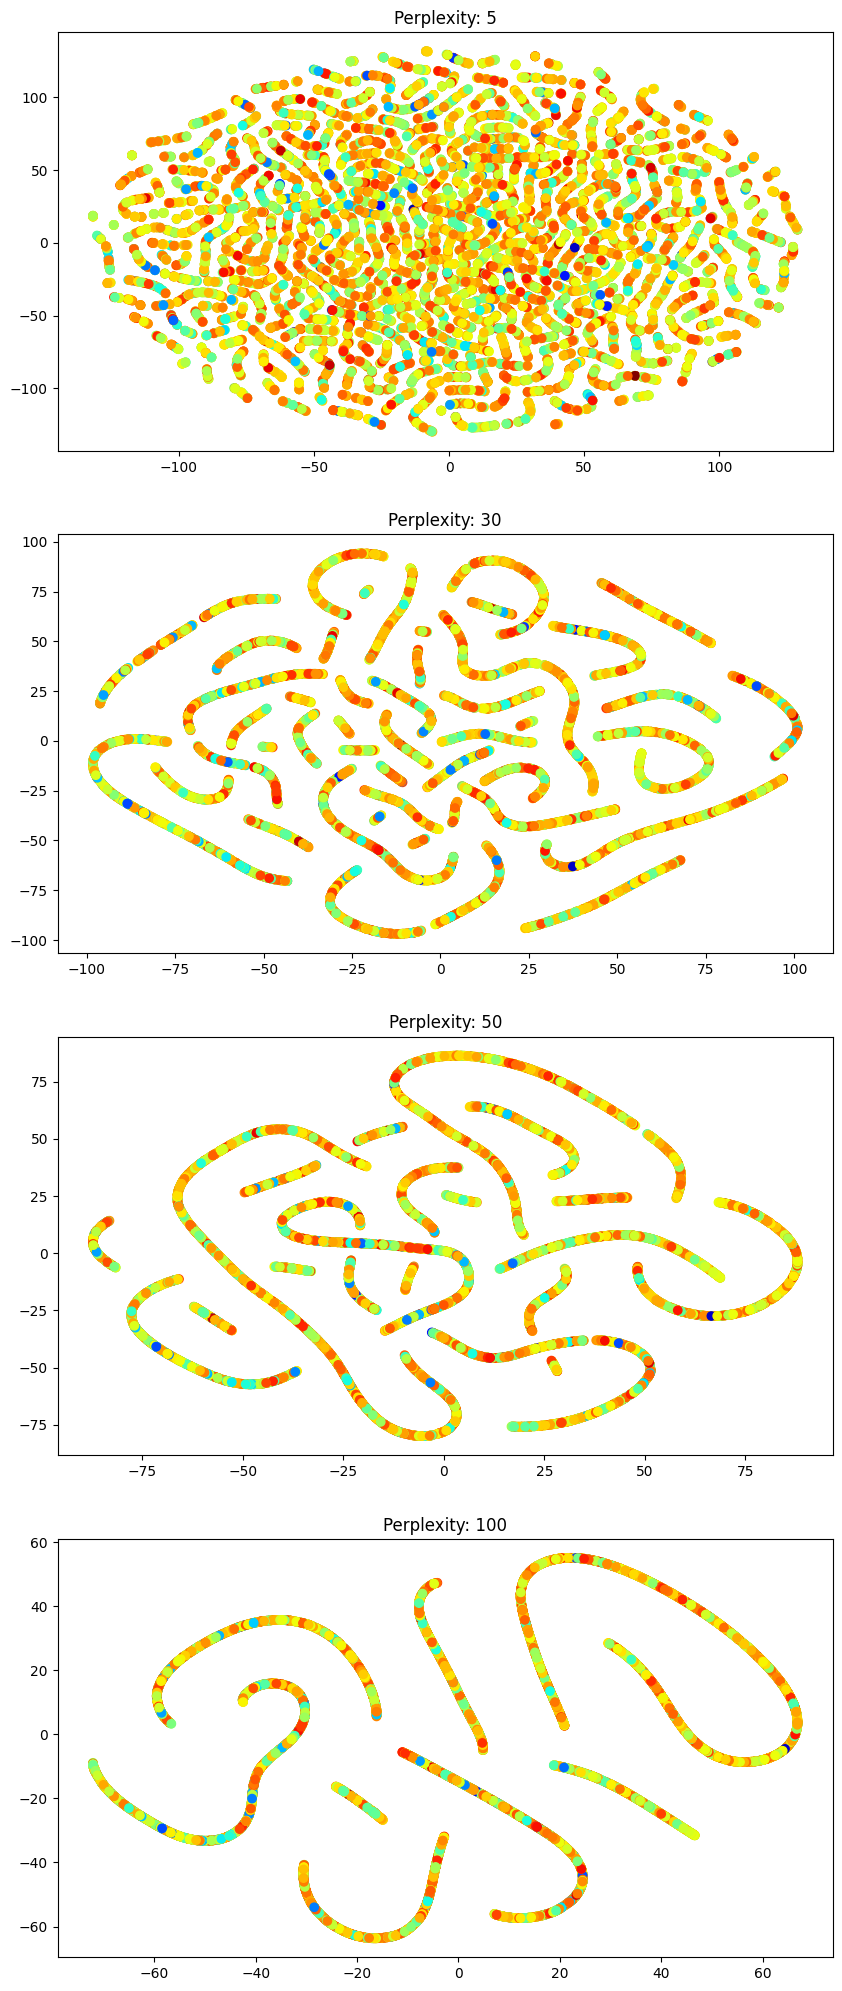

In [26]:
perplexities = [5, 30, 50, 100]
fig, axs = plt.subplots(len(perplexities), 1, figsize=(10, 25))
for i, p in enumerate(perplexities):
    print('Perplexity: {}'.format(p))
    tsne = TSNE(n_components=2, init='random', random_state=42, perplexity=p)
    tsne = tsne.fit(X_train)
    X_train_TSNE = tsne.fit_transform(X_train)
    axs[i].scatter(X_train_TSNE[:, 0], X_train_TSNE[:, 1], c=y_train, cmap='jet')
    axs[i].set_title('Perplexity: {}'.format(p))

plt.show()


## Modeling

#### Linear Regressor

In [27]:
# get data from csv files
X_train = pd.read_csv('X_train.csv')
X_val = pd.read_csv('X_val.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_val = pd.read_csv('y_val.csv')
y_test = pd.read_csv('y_test.csv')


In [28]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

model = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [-1], # use all processors
    'positive': [True, False]
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(0.5, 1)

plt.tight_layout()
plt.show()


' from sklearn.experimental import enable_halving_search_cv\nfrom sklearn.model_selection import HalvingGridSearchCV\nfrom sklearn.linear_model import LinearRegression\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\nrng = np.random.RandomState(0)\n\nmodel = LinearRegression()\n\nparam_grid = {\n    \'fit_intercept\': [True, False],\n    \'copy_X\': [True, False],\n    \'n_jobs\': [-1], # use all processors\n    \'positive\': [True, False]\n}\n\nhgs = HalvingGridSearchCV(\n    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2\n)\nhgs.fit(X_train, y_train)\n\nresults = pd.DataFrame(hgs.cv_results_)\nresults["params_str"] = results.params.apply(str)\nresults.drop_duplicates(subset=("params_str", "iter"), inplace=True)\nmean_scores = results.pivot(\n    index="iter", columns="params_str", values="mean_test_score"\n)\nax = mean_scores.plot(legend=False, alpha=0.6)\n\nlabels = [\n    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidate

#### SVM

In [29]:
""" # Create SVM model in sklearn

# Create the model
SVM_model = SVR(kernel='linear')

# Train the model on the training data
SVM_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = SVM_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """





" # Create SVM model in sklearn\n\n# Create the model\nSVM_model = SVR(kernel='linear')\n\n# Train the model on the training data\nSVM_model.fit(X_train, y_train)\n\n# Evaluate the model on the test data\ny_pred = SVM_model.predict(X_test)\nprint('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))\nprint('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) "

In [30]:
""" # use HalvingGridSearchCV to find the best parameters for SVR
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.svm import SVR
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.RandomState(0)

model = SVR()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.1, 0.2, 0.3, 0.4, 0.5],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=5
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(0.5, 1)

plt.tight_layout()
plt.show() """


' # use HalvingGridSearchCV to find the best parameters for SVR\nfrom sklearn.model_selection import HalvingGridSearchCV\nfrom sklearn.svm import SVR\nimport numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\nrng = np.random.RandomState(0)\n\nmodel = SVR()\n\nparam_grid = {\n    \'C\': [0.1, 1, 10],\n    \'kernel\': [\'linear\', \'rbf\', \'poly\', \'sigmoid\'],\n    \'gamma\': [\'scale\', \'auto\'],\n    \'epsilon\': [0.1, 0.2, 0.3, 0.4, 0.5],\n}\n\nhgs = HalvingGridSearchCV(\n    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=5\n)\nhgs.fit(X_train, y_train)\n\nresults = pd.DataFrame(hgs.cv_results_)\nresults["params_str"] = results.params.apply(str)\nresults.drop_duplicates(subset=("params_str", "iter"), inplace=True)\nmean_scores = results.pivot(\n    index="iter", columns="params_str", values="mean_test_score"\n)\nax = mean_scores.plot(legend=False, alpha=0.6)\n\nlabels = [\n    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs

### KNN

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3725
max_resources_: 11176
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 3725
Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END n_neighbors=3, weights=uniform;, score=(train=-0.154, test=-0.302) total time=   0.1s
[CV 2/2] END n_neighbors=3, weights=uniform;, score=(train=-0.149, test=-0.301) total time=   0.1s
[CV 1/2] END n_neighbors=3, weights=distance;, score=(train=-0.000, test=-0.332) total time=   0.1s
[CV 2/2] END n_neighbors=3, weights=distance;, score=(train=-0.000, test=-0.340) total time=   0.1s
[CV 1/2] END n_neighbors=5, weights=uniform;, score=(train=-0.185, test=-0.270) total time=   0.2s
[CV 2/2] END n_neighbors=5, weights=uniform;, score=(train=-0.180, test=-0.270) total time=   0.1s
[CV 1/2] END n_neighbors=5, weights=distance;, score=(train=-0.000, test=-0.308) total time=   0.2s
[CV 2/2] END n_neighbors=5, weights=distan

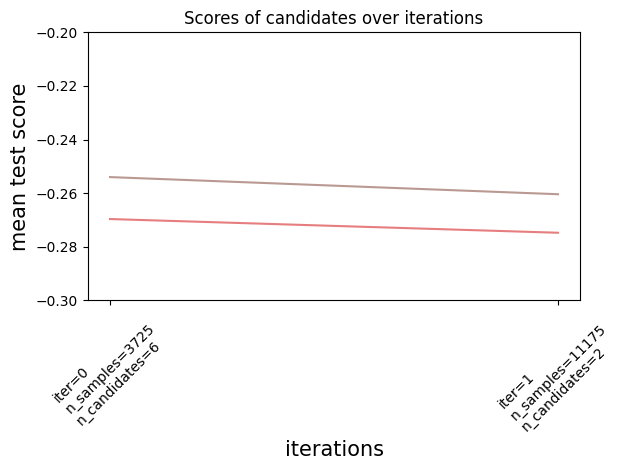

In [31]:
""" n_neighbors = list(range(1, 21))

mse = []
r2 = []
for n in n_neighbors:
    print('\nn_neighbors =', n)
    KNN_model = KNeighborsRegressor(n_neighbors=n)
    KNN_model.fit(X_train, y_train)

    # Evaluate the model on the test data
    y_pred = KNN_model.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))
    print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
    print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred))

# show in the same plot the accuracy, recall and precision for each hyperparameter combination

fig, ax = plt.subplots(figsize=(15,5))

ax1 = sns.lineplot(x=n_neighbors, y=mse, label='mse', marker='o')
ax1 = sns.lineplot(x=n_neighbors, y=r2, label='r2', marker='o')
ax1.set_xlabel('n_neighbors')
plt.xticks(n_neighbors)
plt.grid(True)
plt.legend()
plt.show() """


""" model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)

# predict
y_pred = grid.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """



# use HalvingGridSearchCV to find the best parameters for KNN

rng = np.random.RandomState(0)

model = KNeighborsRegressor()

param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(-0.3, -0.2)

plt.tight_layout()
plt.show()



### Decision Trees

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 137
max_resources_: 11176
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 137
Fitting 2 folds for each of 81 candidates, totalling 162 fits
[CV 1/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=(train=-0.010, test=-0.055) total time=   0.0s
[CV 2/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2;, score=(train=-0.014, test=-0.109) total time=   0.0s
[CV 1/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4;, score=(train=-0.010, test=-0.064) total time=   0.0s
[CV 2/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=4;, score=(train=-0.014, test=-0.086) total time=   0.0s
[CV 1/2] END max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=6;, score=(train=-0.015, test=-0.055) total time=   0.0s
[CV 2/2] END max_depth=3, max_feature

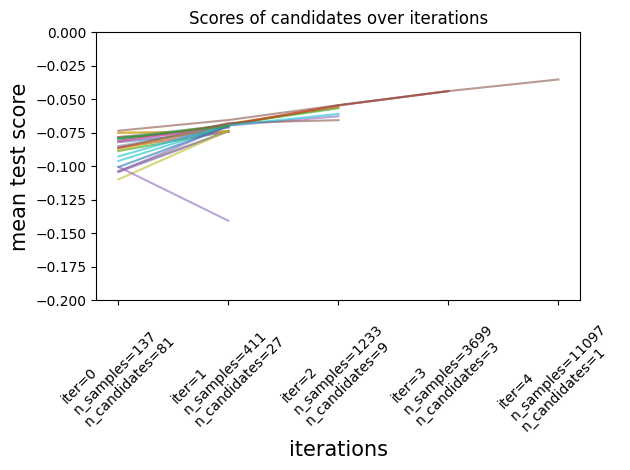

In [32]:
""" DT_model = DecisionTreeRegressor()
DT_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = DT_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """


""" model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X, y)

print(grid.best_params_)

# predict
y_pred = grid.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """

# use HalvingGridSearchCV to find the best parameters for Decision Tree

rng = np.random.RandomState(0)

model = DecisionTreeRegressor()

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(-0.2, 0.0)

plt.tight_layout()
plt.show()



### Ridge

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 3725
max_resources_: 11176
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 3725
Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END ...alpha=0.1;, score=(train=-0.002, test=-0.011) total time=   0.2s
[CV 2/2] END ...alpha=0.1;, score=(train=-0.002, test=-0.011) total time=   0.2s
[CV 1/2] END .....alpha=1;, score=(train=-0.002, test=-0.008) total time=   0.3s
[CV 2/2] END .....alpha=1;, score=(train=-0.002, test=-0.008) total time=   0.3s
[CV 1/2] END ....alpha=10;, score=(train=-0.005, test=-0.008) total time=   0.3s
[CV 2/2] END ....alpha=10;, score=(train=-0.005, test=-0.008) total time=   0.1s
----------
iter: 1
n_candidates: 1
n_resources: 11175
Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV 1/2] END .....alpha=1;, score=(train=-0.004, test=-0.006) total time=   0.2s
[CV 2/2] END .....alpha=1;, score=(train=-0.004, test=-0.00

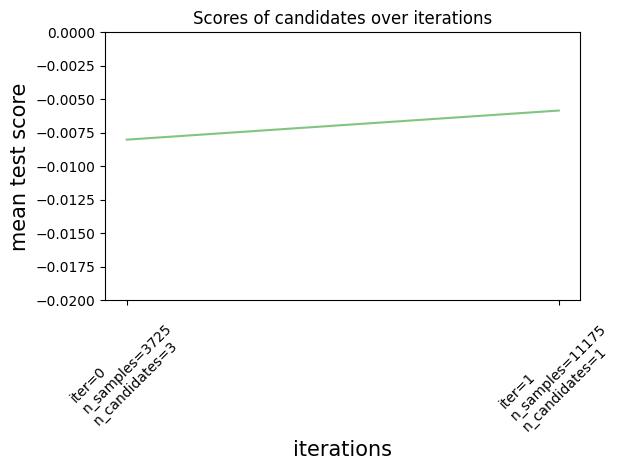

In [33]:
""" # Create Ridge Regression model in sklearn

# Create the model
RR_model = Ridge(alpha=0.1)

# Train the model on the training data
RR_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = RR_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """


""" model = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10],
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)

# predict
y_pred = grid.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """


# use HalvingGridSearchCV to find the best parameters for Ridge Regression

rng = np.random.RandomState(0)

model = Ridge()

param_grid = {
    'alpha': [0.1, 1, 10],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(-0.02, 0.0)

plt.tight_layout()
plt.show()



### Lasso

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1241
max_resources_: 11176
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 1241
Fitting 2 folds for each of 9 candidates, totalling 18 fits
[CV 1/2] END alpha=0.1, max_iter=100;, score=(train=-0.220, test=-0.213) total time=   0.1s
[CV 2/2] END alpha=0.1, max_iter=100;, score=(train=-0.182, test=-0.188) total time=   0.2s
[CV 1/2] END alpha=0.1, max_iter=1000;, score=(train=-0.220, test=-0.213) total time=   0.1s
[CV 2/2] END alpha=0.1, max_iter=1000;, score=(train=-0.182, test=-0.188) total time=   0.1s
[CV 1/2] END alpha=0.1, max_iter=10000;, score=(train=-0.220, test=-0.213) total time=   0.1s
[CV 2/2] END alpha=0.1, max_iter=10000;, score=(train=-0.182, test=-0.188) total time=   0.2s
[CV 1/2] END alpha=1, max_iter=100;, score=(train=-0.224, test=-0.218) total time=   0.1s
[CV 2/2] END alpha=1, max_iter=100;, score=(train=-0.185, test=-0.190) total time=   0.1s


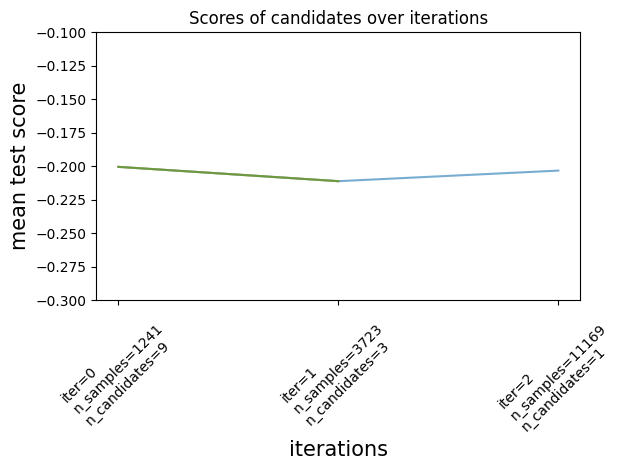

In [34]:
""" # Create Lasso Regression model in sklearn

# Create the model
LR_model = Lasso(alpha=0.1)

# Train the model on the training data
LR_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = LR_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """


""" model = Lasso()

param_grid = {
    'alpha': [0.1, 1, 10],
    'max_iter': [100, 1000, 10000],
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)
# predict
y_pred = grid.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """


# use HalvingGridSearchCV to find the best parameters for Lasso Regression

rng = np.random.RandomState(0)

model = Lasso()

param_grid = {
    'alpha': [0.1, 1, 10],
    'max_iter': [100, 1000, 10000],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(-0.3, -0.1)

plt.tight_layout()
plt.show()


### ElasticNet

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 413
max_resources_: 11176
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 27
n_resources: 413
Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END alpha=0.1, l1_ratio=0.1, max_iter=100;, score=(train=-0.062, test=-0.073) total time=   0.1s
[CV 2/2] END alpha=0.1, l1_ratio=0.1, max_iter=100;, score=(train=-0.060, test=-0.058) total time=   0.1s
[CV 1/2] END alpha=0.1, l1_ratio=0.1, max_iter=1000;, score=(train=-0.062, test=-0.073) total time=   0.1s
[CV 2/2] END alpha=0.1, l1_ratio=0.1, max_iter=1000;, score=(train=-0.060, test=-0.058) total time=   0.1s
[CV 1/2] END alpha=0.1, l1_ratio=0.1, max_iter=10000;, score=(train=-0.062, test=-0.073) total time=   0.1s
[CV 2/2] END alpha=0.1, l1_ratio=0.1, max_iter=10000;, score=(train=-0.060, test=-0.058) total time=   0.1s
[CV 1/2] END alpha=0.1, l1_ratio=0.5, max_iter=100;, score=(train=-0.173, test=-0.197) total tim

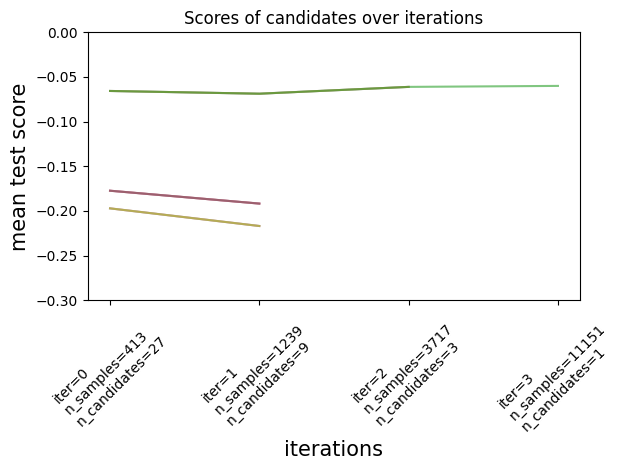

In [35]:
""" # Create ElasticNet Regression model in sklearn

# Create the model
EN_model = ElasticNet(alpha=0.1)

# Train the model on the training data
EN_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = EN_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred))
 """


""" model = ElasticNet()

param_grid = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9],
    'max_iter': [100, 1000, 10000],
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)
# predict
y_pred = grid.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """


# use HalvingGridSearchCV to find the best parameters for ElasticNet Regression

rng = np.random.RandomState(0)

model = ElasticNet()

param_grid = {
    'alpha': [0.1, 1, 10],
    'l1_ratio': [0.1, 0.5, 0.9],
    'max_iter': [100, 1000, 10000],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(-0.3, 0.0)

plt.tight_layout()
plt.show()



### Random Forest Regressor

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1241
max_resources_: 11176
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 1241
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-0.012, test=-0.030) total time=   1.1s
[CV 2/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=(train=-0.012, test=-0.028) total time=   1.2s
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=(train=-0.012, test=-0.029) total time=   1.2s
[CV 2/2] END max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=4, n_estimators=10;, score=(train=-0.012, test=-0.029) total time=   1.2s
[CV 1/2] END max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10;, scor

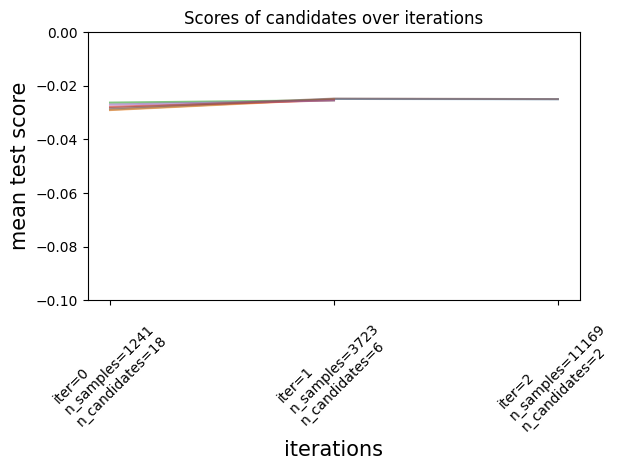

In [36]:
""" # Create Random Forest Regression model in sklearn

# Create the model
RF_model = RandomForestRegressor()

# Train the model on the training data
RF_model.fit(X_train, y_train)

# Evaluate the model on the test data
y_pred = RF_model.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """


""" model = RandomForestRegressor()

param_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)

print(grid.best_params_)

# predict
y_pred = grid.predict(X_test)
print('Mean squared error: %.4f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.4f' % r2_score(y_test, y_pred)) """

# use HalvingGridSearchCV to find the best parameters for Random Forest Regression

rng = np.random.RandomState(0)

model = RandomForestRegressor()

param_grid = {
    'n_estimators': [10],
    'max_depth': [5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['auto', 'sqrt', 'log2'],
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='neg_mean_squared_error'
)
hgs.fit(X_train, y_train)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(-0.1, 0.0)

plt.tight_layout()
plt.show()


### Modeling the problem as classification

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1241
max_resources_: 11176
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 18
n_resources: 1241
Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.973, test=0.490) total time=   0.1s
[CV 2/2] END criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=10;, score=(train=0.977, test=0.556) total time=   0.1s
[CV 1/2] END criterion=gini, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.971, test=0.540) total time=   0.1s
[CV 2/2] END criterion=gini, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=10;, score=(train=0.974, test=0.518) total time=   0.1s
[CV 1/2] END criterion=gini, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=10

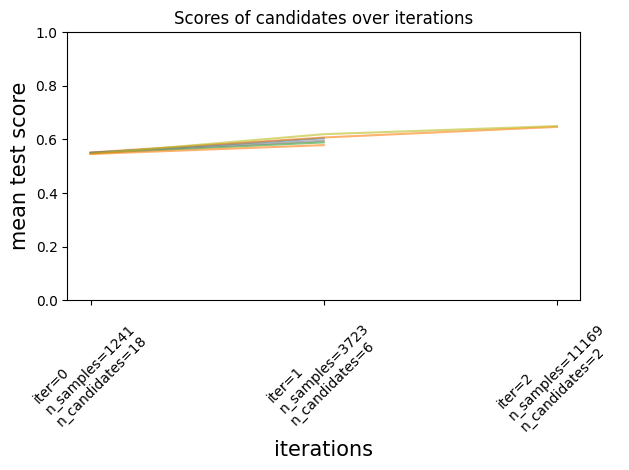

In [37]:
# bin y_train and y_test into 10 bins
# reshape df y_train and y_test to 1D array
y_train_b = np.array(y_train).reshape(-1)
y_test_b = np.array(y_test).reshape(-1)

y_train_binned = pd.cut(y_train_b, 10, labels=False)
y_test_binned = pd.cut(y_test_b, 10, labels=False)

# print('Binned values:', np.unique(y_train_binned))
# display(y_train_binned[:5])

# use the binned values to train the model

""" n_trees = [10, 50, 100]
criterion = ['gini', 'entropy']

hyperparameters = itertools.product(n_trees, criterion)

accuracy = []
recall = []
precision = []

for n, c in hyperparameters:
    print('\nn_trees =', n, '\tcriterion =', c)
    RFC_classifier = RandomForestClassifier(n_estimators=n, criterion=c)
    RFC_classifier.fit(X_train, y_train_binned)

    y_pred = RFC_classifier.predict(X_test)

    # evaluation of y_pred
    accuracy.append(accuracy_score(y_test_binned, y_pred))
    recall.append(recall_score(y_test_binned, y_pred, average='macro'))
    precision.append(precision_score(y_test_binned, y_pred, average='macro'))
    print('Accuracy: %.4f' % accuracy_score(y_test_binned, y_pred))
    print('Recall: %.4f' % recall_score(y_test_binned, y_pred, average='macro'))
    print('Precision: %.4f' % precision_score(y_test_binned, y_pred, average='macro'))

    # display(y_test_binned[:5])
    # display(y_pred[:5])


# show in the same plot the accuracy, recall and precision for each hyperparameter combination

fig, ax = plt.subplots(figsize=(15,5))

ax1 = sns.lineplot(accuracy, label='accuracy', marker='o')
ax1 = sns.lineplot(recall, label='recall', marker='o')
ax1 = sns.lineplot(precision, label='precision', marker='o')
ax1.set_xticklabels(['_','10, gini','10, entropy','50, gini','50, entropy','100, gini','100, entropy'])
ax1.set_xlabel('n_trees, criterion')

plt.legend()
plt.show() """


""" model = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train_binned)

print(grid.best_params_)

# predict
y_pred = grid.predict(X_test)
print('Accuracy: %.4f' % accuracy_score(y_test_binned, y_pred))
print('Recall: %.4f' % recall_score(y_test_binned, y_pred, average='macro'))
print('Precision: %.4f' % precision_score(y_test_binned, y_pred, average='macro')) """

# use HalvingGridSearchCV to find the best parameters for Random Forest Classification

rng = np.random.RandomState(0)

model = RandomForestClassifier()

param_grid = {
    'n_estimators': [10],
    'min_samples_split': [5],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

hgs = HalvingGridSearchCV(
    estimator=model, param_grid=param_grid, random_state=rng, verbose=3, cv=2, scoring='accuracy'
)
hgs.fit(X_train, y_train_binned)

results = pd.DataFrame(hgs.cv_results_)
results["params_str"] = results.params.apply(str)
results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
mean_scores = results.pivot(
    index="iter", columns="params_str", values="mean_test_score"
)
ax = mean_scores.plot(legend=False, alpha=0.6)

labels = [
    f"iter={i}\nn_samples={hgs.n_resources_[i]}\nn_candidates={hgs.n_candidates_[i]}"
    for i in range(hgs.n_iterations_)
]

ax.set_xticks(range(hgs.n_iterations_))
ax.set_xticklabels(labels, rotation=45, multialignment="left")
ax.set_title("Scores of candidates over iterations")
ax.set_ylabel("mean test score", fontsize=15)
ax.set_xlabel("iterations", fontsize=15)

ax.set_ylim(0.0, 1.0)

plt.tight_layout()
plt.show()



### NN

In [51]:
#look for GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print("Device: {}".format(device))


Device: cpu


In [52]:
# Setting the seed for the random number generator.
# reproducibility -> il risultato tra un run e il successivo è lo stesso
def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)


In [53]:
# training process
def train_model(model, criterion, optimizer, epochs, data_loader, val_loader, device, writer):
    n_iter = 0
    patience = 10
    best_loss = np.inf
    best_model = None
    best_epoch = 0

    for epoch in range(epochs):
        model.train()
        # per verificare che ci troviamo in training e non in validation per evitare che il modello aggiorni i pesi
        for data, targets in data_loader:
            # per spostare il minibatch in GPU
            data, targets = data.to(device), targets.to(device)
            # Forward pass -> chiama la funzione forward
            y_pred = model(data)
            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)
            # serve per azzerare il gradiente
            optimizer.zero_grad()
            # la barra separa Loss e la sezione train
            writer.add_scalar("Loss/train", loss, n_iter)
            # Backward pass
            loss.backward()
            # aggiorna i pesi della rete
            optimizer.step()
            n_iter += 1

        
        # validation
        loss_val, _, _ = test_model(model, criterion, val_loader, device)

        # early stopping
        if loss_val <= best_loss:
            best_loss = loss_val
            best_model = copy.deepcopy(model)
            best_epoch = epoch+1
            patience = 10
        else:
            patience = patience - 1
            if patience == 0:
                print("\nEarly stopping", end='')
                return best_model, best_epoch

        if best_loss == np.inf:
            print("No validation loss available", end='\n')
            return model, epoch
        
        print("Epoch: [ {} / {} ],\tPatience: {},\tBest loss: {:.4f},\tVal Loss: {:.4f}".format(epoch+1, epochs, patience, best_loss, loss_val), end='\r')
        writer.add_scalar("Loss/val", loss_val, epoch)
    
    return best_model, best_epoch



#evaluation process -> utilizzata sia per la validation che per il test
def test_model(model, criterion, data_loader, device):
    model.eval() # per evitare che il modello aggiorni i pesi
    loss = 0
    y_pred = torch.tensor([]).to(device)
    y_true = torch.tensor([]).to(device)
    
    for data, targets in data_loader:
        data, targets = data.to(device), targets.to(device)
        output = model(data)
        loss += criterion(output.squeeze(), targets)
        y_pred = torch.cat((y_pred, output), 0)
        y_true = torch.cat((y_true, targets), 0)

    return loss/len(data_loader), y_pred.squeeze(), y_true

In [54]:
class NN(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_prob=0):
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.dp = dropout_prob
        
        model = [
            nn.Linear(self.input_size, self.hidden_sizes[0]),
            nn.ReLU(),
            nn.Dropout(self.dp)
        ]
        
        for i in range(1, len(self.hidden_sizes)):
            model.append(nn.Linear(self.hidden_sizes[i-1], self.hidden_sizes[i]))
            model.append(nn.ReLU())
            model.append(nn.Dropout(self.dp))
        
        model.append(nn.Linear(self.hidden_sizes[-1], 1))
        
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        return x.squeeze()


In [55]:
class RatingDataset(Dataset):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        
        self.num_features = X_train.shape[1]
        
        self.X_train = X_train.to_numpy()
        self.y_train = y_train.to_numpy()
        self.X_val = X_val.to_numpy()
        self.y_val = y_val.to_numpy()
        self.X_test = X_test.to_numpy()
        self.y_test = y_test.to_numpy()

        self.val_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=y_val.shape[0], shuffle=False)
        self.test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=y_test.shape[0], shuffle=False)
    
    def get_train_loader(self, batch_size):
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_train, dtype=torch.float32), torch.tensor(self.y_train, dtype=torch.float32)), batch_size=batch_size, shuffle=True)
    
    def get_val_test_loaders(self, batch_size):
        val = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_val, dtype=torch.float32), torch.tensor(self.y_val, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
        test = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(torch.tensor(self.X_test, dtype=torch.float32), torch.tensor(self.y_test, dtype=torch.float32)), batch_size=batch_size, shuffle=False)
        return val, test

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx]


In [65]:
hidden_sizes = [[512, 256, 128]]
batch_sizes = [64]
learning_rate = [0.001]
dropout_prob = [0.0]

nums_epochs = [200]
momentum = [0.9]
scheduler_step_size = [10]
scheduler_gamma = [0.1]
val_test_batch_sizes = [X_train.shape[0]]

hyperparameters = itertools.product(hidden_sizes, nums_epochs, batch_sizes, learning_rate, dropout_prob, val_test_batch_sizes, momentum, scheduler_step_size, scheduler_gamma)


In [66]:
# data
my_dataset = RatingDataset(X_train, y_train, X_val, y_val, X_test, y_test)

my_table = pd.DataFrame(columns=['hidden_size', 'num_epochs', 'batch_size', 'learning_rate', 'dropout_prob', 'MSE', 'R2'])

#grid search loop
for i, [hidden_size, num_epochs, batch, learning_rate, dropout_prob, val_test_batch_size, momentum, scheduler_step_size, scheduler_gamma] in enumerate(hyperparameters):
        
    val_loader, test_loader = my_dataset.get_val_test_loaders(val_test_batch_size)
    print("\nIter: {}, hidden_size: {}, num_epochs: {}, batch_size: {}, learning_rate: {}, dropout_prob: {}, val_test_batch_size: {}, momentum: {}, scheduler_step_size: {}, scheduler_gamma: {}".format(i+1, hidden_size, num_epochs, batch, learning_rate, dropout_prob, val_test_batch_size, momentum, scheduler_step_size, scheduler_gamma))

    log_name = "dim:"+str(hidden_size)+"-ep:"+str(num_epochs)+"-bs:"+str(batch) + "-lr:"+str(learning_rate) + "-dp:"+str(dropout_prob)

    #start tensorboard
    writer = SummaryWriter('runs/'+log_name)

    
    train_loader = my_dataset.get_train_loader(batch)

    #define architecture, loss and optimizer
    model = NN(my_dataset.num_features, hidden_size, dropout_prob)

    criterion = torch.nn.MSELoss()

    #train and validate
    model.to(device)

    # A natural property of stochastic gradient descent: if the learning rate is too large, SGD can diverge into infinity
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5, amsgrad=True, eps=1e-8, betas=(0.9, 0.999))
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    model, n_epochs = train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device, writer)

    try:
        mse, y_t, y_p = test_model(model, criterion, test_loader, device)
        r2 = r2_score(y_t.cpu().detach().numpy(), y_p.cpu().detach().numpy())
        print("\nMSE: {}".format(mse))
        print("R2: {}".format(r2))
        
        my_table.loc[my_table.shape[0]] = [hidden_size, n_epochs, batch, learning_rate, dropout_prob, mse.item(), r2]
        writer.add_scalar('metrics/test mse', mse.item())
        if not os.path.exists('models'):
            os.makedirs('models')
        torch.save(model.state_dict(), 'models/'+log_name)
    
    except:
        pass
    

    # hidden_size, num_epochs, batch, learning_rate, dropout_prob, val_test_batch_size
    # writer.add_hparams(
        # {'lr': learning_rate, 'bsize': batch, 'dim': hidden_size, 'num_epochs': num_epochs, 'dropout_prob': dropout_prob, 'val_test_batch_size': val_test_batch_size},
        # {'hparam/mse': mse.item(), 'hparam/r2': r2}
    # )

    writer.flush()
    
writer.close()



Iter: 1, hidden_size: [512, 256, 128], num_epochs: 200, batch_size: 64, learning_rate: 0.001, dropout_prob: 0.0, val_test_batch_size: 11176, momentum: 0.9, scheduler_step_size: 10, scheduler_gamma: 0.1
Epoch: [ 44 / 200 ],	Patience: 1,	Best loss: 0.8258,	Val Loss: 1.6784879.0791
Early stopping
MSE: 0.800781786441803
R2: -0.5221799661105204


### Tabular model
The next cells implement the TabNet model

In [69]:
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import TabNetModelConfig

In [73]:
# create df from X_train and y_train
df = pd.DataFrame(X_train)
df['mean_rating'] = y_train

train_tabular, test_tabular = train_test_split(df, random_state=42, test_size=0.1)
train_tabular, val_tabular = train_test_split(train_tabular, random_state=42, test_size=0.1)

label = ['mean_rating']
categorical_columns = list(categories)

# continuous_columns is all_columns - [label, categorical_columns]
continuous_columns = [column for column in df.columns if column not in (categorical_columns + label)]

data_config = DataConfig(
    target=label,
    continuous_cols=continuous_columns,
    categorical_cols=categorical_columns,
    # date_columns=[],
    # encode_date_columns=True,
    validation_split=0.1,
    # continuous_feature_transform=["yeo-johnson", "box-cox", "quantile_normal", "quantile_uniform", "yeo-johnson", "box-cox", "quantile_normal", "quantile_uniform"],
    # normalize_continuous_features=True,
)

optimizer_config = OptimizerConfig()

trainer_config = TrainerConfig(
    auto_lr_find=True,  # Runs the LRFinder to automatically derive a learning rate
    batch_size=64,
    max_epochs=100,
    early_stopping_patience=10
)

model_config = TabNetModelConfig(task='regression')

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

tabular_model.fit(train=train_tabular, validation=val_tabular, seed=42)


result = tabular_model.evaluate(test_tabular)

2023-03-26 17:02:47,168 - {pytorch_tabular.tabular_model:102} - INFO - Experiment Tracking is turned off
Global seed set to 42
2023-03-26 17:02:47,265 - {pytorch_tabular.tabular_model:465} - INFO - Preparing the DataLoaders
2023-03-26 17:02:47,282 - {pytorch_tabular.tabular_datamodule:286} - INFO - Setting up the datamodule for regression task
2023-03-26 17:02:49,021 - {pytorch_tabular.tabular_model:508} - INFO - Preparing the Model: TabNetModel
2023-03-26 17:02:49,170 - {pytorch_tabular.tabular_model:264} - INFO - Preparing the Trainer
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
2023-03-26 17:02:49,242 - {pytorch_tabular.tabular_model:558} - INFO - Auto LR Find Started


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.13182567385564073
Restoring states from the checkpoint path at /home/nicolopizzo/Documents/Projects/data-analytics/.lr_find_07d42e14-3e7a-4c36-9ba3-20e4151ef0c7.ckpt
Restored all states from the checkpoint file at /home/nicolopizzo/Documents/Projects/data-analytics/.lr_find_07d42e14-3e7a-4c36-9ba3-20e4151ef0c7.ckpt
2023-03-26 17:02:53,535 - {pytorch_tabular.tabular_model:560} - INFO - Suggested LR: 0.13182567385564073. For plot and detailed analysis, use `find_learning_rate` method.
2023-03-26 17:02:53,537 - {pytorch_tabular.tabular_model:566} - INFO - Training Started


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │ 82.9 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 82.9 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 82.9 K                                                                                               
Total estimated model params size (MB): 0

Output()

2023-03-26 17:07:27,423 - {pytorch_tabular.tabular_model:568} - INFO - Training the model completed
2023-03-26 17:07:27,424 - {pytorch_tabular.tabular_model:1207} - INFO - Loading the best model


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.0174245722591877     │
│  test_mean_squared_error  │    0.0174245722591877     │
└───────────────────────────┴───────────────────────────┘